# Neural Networks and Deep Learning Notes

Notes and equations from [neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com/)

# Chapter 4

## Deep Neural Networks Motivation

- Divide complex tasks into multiple layers.
- Using an analogy to circuit design, it's much simpler to break up a complex task into a multi-layer circuit than it is to build a single layer circuit for that task.
- Potential problem: when introducing many layers, they can learn at different speeds, making it difficult to train the entire network using gradient-based techniques.

## The vanishing, exploding, unstable gradient problems

- In an example, he shows how the neurons in the second hidden layer are learning (changing) more quickly than neurons in the first hidden layer, and neurons in the third hidden layer are learning faster than the second hidden layer.

![](http://neuralnetworksanddeeplearning.com/images/training_speed_3_layers.png)

- This exemplifies **vanishing gradient**, a problem in which earlier layers learn much more slowly than later layers.
- The opposite can also occur- the **exploding gradient** problem, where the gradient gets much larger in earier layers.
- More generally, the **unstable gradient** problem posits that when using standard gradient-based learning techniques, different layers in the network will tend to learn at wildly different speeds.
- This can all be more or less explained by breaking the network down to a series of single-neuron layers.

## Other obstacles in deep learning

- Sigmoid activation functions can cause problems training deep networks.
    - Sigmoids can cause activations in the final hidden layer to saturate near 0 early in training.
    - Some alternative functions can be used to avoid this.
- Random weight initialization and momentum schedule in momentum-based SGD can make a substantial difference in training deep networks.

In [1]:
from __future__ import print_function

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.1
set_session(tf.Session(config=config))
print('done')

Using TensorFlow backend.


done


In [37]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

batch_size = 10
nb_train = 60000
nb_test = 10000
nb_pixel = 784
nb_classes = 10
nb_epochs = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape and scale the images.
X_train = X_train.reshape(nb_train, nb_pixel).astype('float32') / 255
X_test = X_test.reshape(nb_test, nb_pixel).astype('float32') / 255

X_train = X_train[:nb_train]
y_train = y_train[:nb_train]

print(X_train.shape[0], 'training')
print(X_test.shape[0], 'testing')

# Convert class labels e.g. '3' to binary class matrices e.g. [0 0 0 1 0 ..].
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

# Define a callback class to store the weights after each batch.
class WeightWatcher(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.weights=[[] for x in range(len(self.model.get_weights()))]
        return
    def on_batch_end(self, batch, logs={}):
        for i,w in enumerate(self.model.get_weights()):
            self.weights[i].append(w)
        return

ww = WeightWatcher()
cbs = [ww]
    
model = Sequential()
model.add(Dense(60, input_shape=(nb_pixel,), activation='sigmoid', init='normal'))
model.add(Dense(60, activation='sigmoid', init='normal'))
model.add(Dense(60, activation='sigmoid', init='normal'))
model.add(Dense(10, activation='sigmoid', init='normal'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.15), metrics=['accuracy'])
result = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epochs,
                  verbose=1, validation_data=(X_test, y_test), callbacks=cbs)
score = model.evaluate(X_test, y_test, verbose=0)
print('holdout accuracy', score[1])

60000 training
10000 testing
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 23s - loss: 2.3027 - acc: 0.1112 - val_loss: 2.3021 - val_acc: 0.1135
Epoch 2/10
60000/60000 [==============================] - 22s - loss: 2.3017 - acc: 0.1124 - val_loss: 2.3018 - val_acc: 0.1135
Epoch 3/10
60000/60000 [==============================] - 22s - loss: 2.3016 - acc: 0.1124 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 4/10
60000/60000 [==============================] - 22s - loss: 2.3015 - acc: 0.1124 - val_loss: 2.3012 - val_acc: 0.1135
Epoch 5/10
60000/60000 [==============================] - 22s - loss: 2.3012 - acc: 0.1124 - val_loss: 2.3003 - val_acc: 0.1135
Epoch 6/10
60000/60000 [==============================] - 22s - loss: 2.1318 - acc: 0.1353 - val_loss: 1.6010 - val_acc: 0.3258
Epoch 7/10
60000/60000 [==============================] - 21s - loss: 0.7190 - acc: 0.7532 - val_loss: 0.4115 - val_acc: 0.8811
Epoch 8/10
60000/60000 [=

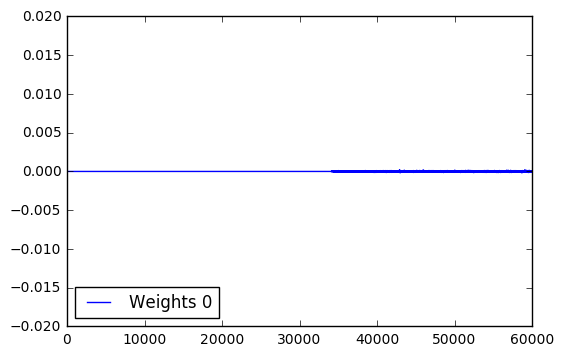

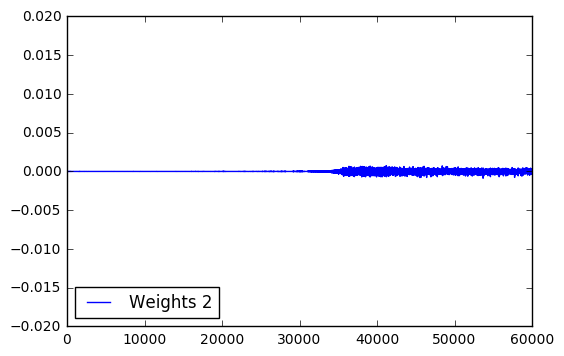

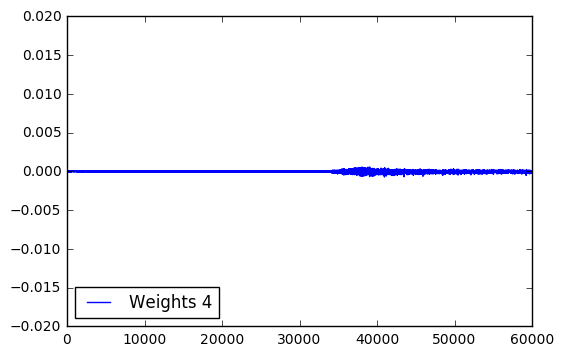

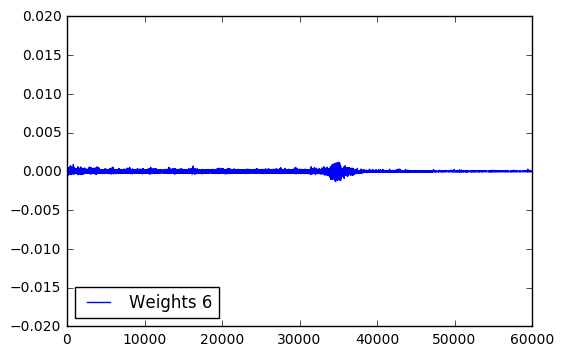

In [38]:
# An attempt to plot the changes in weights over time.
# This plots the mean difference in weights at iteration n minus iteration n - 1.
# This at least partially demonstrates the vanishing gradient problem.
# Notice the line gets thicker from the earlier to later layers.
# This indicates those layers are changing more and presumably learning more quickly.

import numpy as np
import matplotlib.pyplot as plt

for i,layer in enumerate(ww.weights):
    # Skip the odd indices because they are biases.
    if i % 2 == 1: continue
    diffs = [np.mean(after - before) for (before,after) in zip(layer[0:-1], layer[1:])]
    label = 'Weights ' if i % 2 == 0 else 'Biases '
    label += str(i)
    plt.plot(diffs, label=label)
    plt.ylim(-0.02, 0.02)
    plt.legend(loc='lower left')
    plt.show()